# Week 6: GEPA Circle Packing Optimization

This notebook implements circle packing optimization using GEPA's `optimize_anything` API with **OpenAI o3-mini**.

## Approach

We use **Agent Architecture Evolution** mode where:
- The **Reflection LM** (OpenAI o3-mini) iteratively improves the solver code
- The **Solver Code** internally calls an LLM to suggest packing strategies
- All computations happen **locally** using numpy/scipy
- The **Evaluator** validates solutions **independently** and provides diagnostic feedback (ASI)

## Key Features

1. **Local Execution**: LLM suggests strategies, we compute circles locally
2. **Independent Validation**: We don't trust solver's claimed score - we validate and score ourselves
3. **Strict 1:1 Budget**: Budget=10 means exactly 20 API calls (10 reflection + 10 solver)
4. **Cost Controlled**: Maximum 1 LLM call per solver execution

In [1]:
# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tempfile
import traceback
from pathlib import Path

# Add workspace root to path to use LOCAL gepa instead of pip-installed version
workspace_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(workspace_root))

# GEPA imports (from LOCAL folder)
from gepa.optimize_anything import (
    optimize_anything, 
    GEPAConfig, 
    EngineConfig, 
    ReflectionConfig
)

# Verify we're using the local version
import gepa
gepa_path = Path(gepa.__file__).parent
print(f"[OK] Using LOCAL GEPA from: {gepa_path}")

# Configuration
LLM_MODEL = 'o3-mini'
REFLECTION_MODEL = 'openai/o3-mini'
NUM_CIRCLES = 26
TARGET_SUM_RADII = 2.636

# Load API key (OpenAI)
api_key_file = '../api_key.txt'
with open(api_key_file, 'r') as f:
    api_key = f.read().strip()

print(f"[OK] API key loaded (length: {len(api_key)})")
print(f"[OK] Using OpenAI model: {LLM_MODEL}")
print(f"[OK] Reflection model: {REFLECTION_MODEL}")


[OK] Using LOCAL GEPA from: c:\Users\winso\stat 4830\STAT-4830-AlphaGrad-project\gepa
[OK] API key loaded (length: 164)
[OK] Using OpenAI model: o3-mini
[OK] Reflection model: openai/o3-mini


In [2]:
# Test OpenAI connection
from openai import OpenAI

client = OpenAI(api_key=api_key)
try:
    test_response = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role": "user", "content": "Reply with just: test"}],
        max_completion_tokens=10
    )
    print(f"[OK] OpenAI API working: {test_response.choices[0].message.content}")
except Exception as e:
    print(f"[ERROR] OpenAI connection failed: {e}")
    print(f"Please ensure api_key.txt contains a valid OpenAI API key (starts with sk-)")

[OK] OpenAI API working: 


In [4]:
# Define the seed solver code (inline, no external imports)
SEED_SOLVER = """
import numpy as np
import json
import random

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Global best score tracking: (sum_radii, circles_list)
global_best_score = (0.0, [])

MAX_LLM_CALLS = 1

def solve_packing(llm_function, n=26):
    '''LLM suggests STRATEGY, we EXECUTE it locally with actual computation.'''
    global global_best_score
    
    prompt = f'''You are an expert at circle packing optimization.

For packing {n} circles in the unit square [0,1]×[0,1] to maximize sum of radii:

Suggest the best packing ALGORITHM/STRATEGY. Consider:
- Grid layout (square or hexagonal grid)
- Radius sizing (uniform, variable, or adaptive)
- Positioning approach (centered, boundary-aware, optimized spacing)

Constraints:
1. No overlap: distance between centers >= sum of radii
2. Boundaries: circles fully inside [0,1]×[0,1]

Respond with a brief strategy description focusing on:
1. Layout pattern (e.g., "hexagonal grid", "square grid", "concentric rings")
2. Radius approach (e.g., "uniform radius", "larger in center", "adaptive")
3. Key parameters (e.g., grid size, spacing ratio)

Keep it concise (2-3 sentences). I will IMPLEMENT and COMPUTE locally.
'''
    
    strategy = "square grid with uniform radius"
    try:
        response = llm_function(prompt)
        if response and len(response) > 10:
            strategy = response.lower()
    except Exception:
        pass
    
    # IMPLEMENT STRATEGY LOCALLY
    circles = []
    if "hexagon" in strategy or "hex" in strategy:
        circles = _hexagonal_grid(n)
    elif "concentric" in strategy or "ring" in strategy:
        circles = _concentric_layout(n)
    elif "adaptive" in strategy or "variable" in strategy:
        circles = _adaptive_grid(n)
    else:
        circles = _square_grid(n)
    
    # Update global best score tracking
    sum_radii = sum(c[2] for c in circles)
    if sum_radii > global_best_score[0]:
        global_best_score = (sum_radii, circles.copy())
        
        # Save best score to file
        try:
            import os
            best_score_data = {
                "sum_radii": float(sum_radii),
                "circles": [[float(c[0]), float(c[1]), float(c[2])] for c in circles]
            }
            with open('best_score.json', 'w') as f:
                json.dump(best_score_data, f, indent=2)
        except Exception:
            pass
    
    return circles


def _square_grid(n):
    circles = []
    grid_size = int(np.ceil(np.sqrt(n)))
    spacing = 1.0 / (grid_size + 1)
    radius = spacing * 0.4
    
    for i in range(n):
        row = i // grid_size
        col = i % grid_size
        x = (col + 1) * spacing
        y = (row + 1) * spacing
        circles.append([float(x), float(y), float(radius)])
    
    return circles


def _hexagonal_grid(n):
    circles = []
    rows = int(np.ceil(np.sqrt(n / 0.866)))
    cols_per_row = int(np.ceil(n / rows))
    
    row_spacing = 1.0 / (rows + 1)
    col_spacing = 1.0 / (cols_per_row + 1)
    radius = min(row_spacing, col_spacing) * 0.45
    
    idx = 0
    for row in range(rows):
        offset = (row % 2) * col_spacing * 0.5
        for col in range(cols_per_row):
            if idx >= n:
                break
            x = (col + 1) * col_spacing + offset
            y = (row + 1) * row_spacing
            if x - radius >= 0 and x + radius <= 1:
                circles.append([float(x), float(y), float(radius)])
                idx += 1
        if idx >= n:
            break
    
    while len(circles) < n:
        circles.append([0.5, 0.5, 0.01])
    
    return circles


def _concentric_layout(n):
    circles = []
    center_r = 0.15
    circles.append([0.5, 0.5, center_r])
    
    remaining = n - 1
    ring_radius = 0.35
    circles_in_ring = remaining
    angle_step = 2 * np.pi / circles_in_ring
    
    for i in range(circles_in_ring):
        angle = i * angle_step
        x = 0.5 + ring_radius * np.cos(angle)
        y = 0.5 + ring_radius * np.sin(angle)
        r = 0.08
        
        if x - r >= 0 and x + r <= 1 and y - r >= 0 and y + r <= 1:
            circles.append([float(x), float(y), float(r)])
    
    while len(circles) < n:
        circles.append([0.1 + len(circles) * 0.02, 0.1, 0.02])
    
    return circles


def _adaptive_grid(n):
    circles = []
    grid_size = int(np.ceil(np.sqrt(n)))
    spacing = 1.0 / (grid_size + 1)
    
    for i in range(n):
        row = i // grid_size
        col = i % grid_size
        x = (col + 1) * spacing
        y = (row + 1) * spacing
        
        dist_from_center = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
        radius = spacing * (0.45 - dist_from_center * 0.2)
        radius = max(radius, spacing * 0.2)
        
        circles.append([float(x), float(y), float(radius)])
    
    return circles


if __name__ == "__main__":
    with open('api_key.txt', 'r') as f:
        api_key = f.read().strip()
    
    try:
        from openai import OpenAI
        client = OpenAI(api_key=api_key)
        
        def llm_call(prompt):
            response = client.chat.completions.create(
                model='o3-mini',
                messages=[{"role": "user", "content": prompt}],
                temperature=1.0,
                max_completion_tokens=2000
            )
            return response.choices[0].message.content
    except Exception:
        def llm_call(prompt):
            return "square grid with uniform radius"
    
    circles = solve_packing(llm_call, n=26)
    result = {
        "circles": circles,
        "sum_radii": float(sum(c[2] for c in circles))
    }
    
    print(json.dumps(result))
"""

print("[OK] Seed solver defined")
print(f"    Length: {len(SEED_SOLVER)} characters")

[OK] Seed solver defined
    Length: 5553 characters


In [5]:
# Define the evaluator (inline, no external imports)
def evaluate(candidate: dict, example=None) -> tuple[float, dict]:
    """
    Evaluator that runs solver code LOCALLY and validates INDEPENDENTLY.
    We do NOT trust the solver's claimed score.
    """
    solver_code = candidate.get('solver_code', '')
    n = NUM_CIRCLES
    
    if not solver_code or not solver_code.strip():
        return 0.0, {"score": 0.0, "error": "Empty solver code", "sum_radii": 0.0}
    
    # Write code to temp file and execute LOCALLY
    with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False, encoding='utf-8') as f:
        f.write(solver_code)
        temp_path = f.name
    
    try:
        # Execute with timeout
        result = subprocess.run(
            ['python', temp_path],
            capture_output=True,
            text=True,
            timeout=300,
        )
        
        if result.returncode != 0:
            return 0.0, {
                "score": 0.0,
                "error": f"Execution failed: {result.returncode}",
                "stderr": result.stderr[-500:],
                "sum_radii": 0.0
            }
        
        # Parse JSON output
        output = json.loads(result.stdout.strip())
        circles_list = output.get('circles', [])
        solver_claimed_score = output.get('sum_radii', None)
        
        if not circles_list or len(circles_list) != n:
            return 0.0, {"score": 0.0, "error": f"Expected {n} circles, got {len(circles_list)}", "sum_radii": 0.0}
        
        circles = np.array(circles_list, dtype=float)
        centers = circles[:, :2]
        radii = circles[:, 2]
        
        # MANUAL VALIDATION - we check constraints ourselves
        valid = True
        tolerance = 1e-9
        
        # Check boundaries
        for i in range(n):
            x, y, r = circles[i]
            if x - r < -tolerance or x + r > 1 + tolerance:
                valid = False
                break
            if y - r < -tolerance or y + r > 1 + tolerance:
                valid = False
                break
        
        # Check overlaps
        if valid:
            for i in range(n):
                for j in range(i + 1, n):
                    dist = np.sqrt(np.sum((centers[i] - centers[j]) ** 2))
                    if dist < radii[i] + radii[j] - tolerance:
                        valid = False
                        break
                if not valid:
                    break
        
        # Calculate score OURSELVES (don't trust solver's claim)
        sum_radii = float(np.sum(radii)) if valid else 0.0
        
        # Check if solver lied
        score_mismatch = False
        if solver_claimed_score is not None:
            if abs(float(solver_claimed_score) - sum_radii) > 1e-6:
                score_mismatch = True
        
        return sum_radii, {
            "score": sum_radii,
            "sum_radii": sum_radii,
            "solver_claimed_score": solver_claimed_score,
            "score_mismatch": score_mismatch,
            "validation_passed": valid,
            "target": TARGET_SUM_RADII,
            "gap": TARGET_SUM_RADII - sum_radii,
            "circles": circles_list if valid else [],
        }
        
    except subprocess.TimeoutExpired:
        return 0.0, {"score": 0.0, "error": "Timeout after 300s", "sum_radii": 0.0}
    except Exception as e:
        return 0.0, {"score": 0.0, "error": f"Error: {str(e)}", "sum_radii": 0.0}
    finally:
        Path(temp_path).unlink(missing_ok=True)

print("[OK] Evaluator defined (validates independently)")

[OK] Evaluator defined (validates independently)


In [23]:
# Set API key for LiteLLM (used by GEPA's reflection LM)
os.environ['OPENAI_API_KEY'] = api_key

# Configuration
BUDGET = 100  # Number of evaluations (will make exactly 20 API calls total)

print("="*80)
print(f"GEPA Circle Packing Optimization")
print("="*80)
print(f"Budget: {BUDGET} evaluations")
print(f"Expected API calls: {2 * BUDGET} (strict 1:1 ratio)")
print(f"  - Reflection calls: {BUDGET}")
print(f"  - Solver calls: {BUDGET}")
print(f"Target sum of radii: {TARGET_SUM_RADII}")
print("="*80)

GEPA Circle Packing Optimization
Budget: 100 evaluations
Expected API calls: 200 (strict 1:1 ratio)
  - Reflection calls: 100
  - Solver calls: 100
Target sum of radii: 2.636


Starting optimization...

Iteration 0: Base program full valset score: 0.0 over 1 / 1 examples
Iteration 1: Selected program 0 score: 0.0
Iteration 1: Proposed new text for solver_code: #!/usr/bin/env python3
import numpy as np
import json
import random
import os
import google.generativeai as palm

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Global best score tracking: (sum_radii, circles_list)
global_best_score = (0.0, [])

MAX_LLM_CALLS = 1

def solve_packing(llm_function, n=26):
    """
    Uses LLM to suggest a circle packing strategy for n circles in [0,1]x[0,1].
    Computes circle positions and radii based on the strategy and returns a list of circles.
    Each circle is represented as [x, y, r].
    """
    global global_best_score

    prompt = f'''You are an expert at circle packing optimization.

For packing {n} circles in the unit square [0,1]×[0,1] to maximize the sum of radii:

Suggest the best packing AL

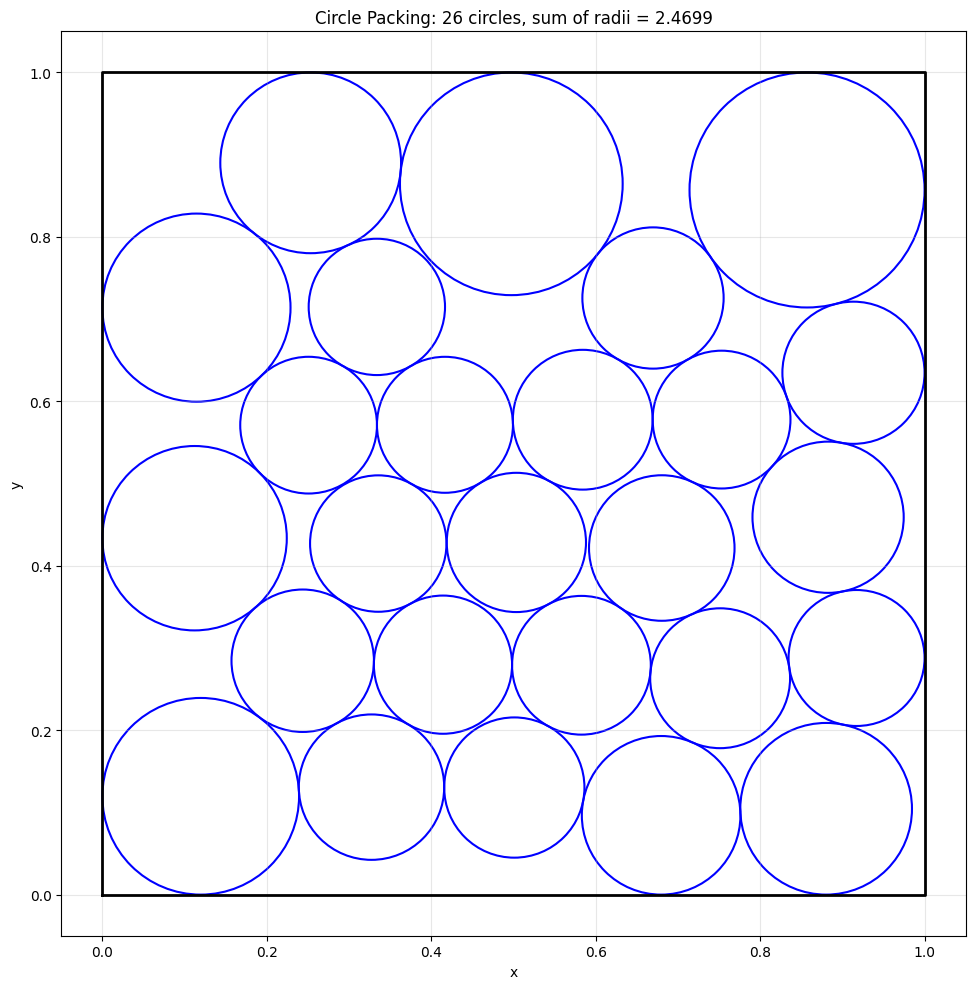


[OK] Visualization complete!


In [24]:
# Run GEPA optimization
print("Starting optimization...\n")

result = optimize_anything(
    seed_candidate={"solver_code": SEED_SOLVER},
    evaluator=evaluate,
    objective=(
        f"Optimize a Python program that uses an LLM (OpenAI {LLM_MODEL}) to suggest "
        f"circle packing strategies for n={NUM_CIRCLES} circles in the unit square [0,1]×[0,1]. "
        "The program should maximize the sum of radii while satisfying all constraints. "
        "Output must be valid JSON with format: {\"circles\": [[x,y,r], ...], \"sum_radii\": float}"
    ),
    background=(
        "The solver receives an llm_function(prompt) -> text that it can call. "
        "The solver should craft effective prompts to guide the LLM, parse responses robustly, "
        "and may apply local optimization or validation steps. "
        "CRITICAL: DO NOT SEARCH FOR THE SOLUTION. "
        "\n\nConstraints:"
        "\n- No overlap: distance between any two circle centers >= sum of their radii"
        "\n- Boundaries: for each circle at (x,y) with radius r: 0 <= x-r, x+r <= 1, 0 <= y-r, y+r <= 1"
        "\n- Must output exactly 26 circles"
        "\n\nThe solver code should be a complete Python script that:"
        "\n1. Imports necessary libraries (numpy, json, google.generativeai)"
        "\n2. Defines solve_packing(llm_function, n=26) -> list"
        "\n3. Has __main__ block that configures Gemini and outputs JSON"
    ),
    config=GEPAConfig(
        engine=EngineConfig(
            max_metric_calls=BUDGET,
            cache_evaluation=True,
            max_candidate_proposals=(BUDGET)  # Strict 1:1 - only 1 proposal per eval
        ),
        reflection=ReflectionConfig(
            reflection_lm=REFLECTION_MODEL,
            reflection_minibatch_size=1  # Process 1 trajectory at a time
        )
    )
)

print("\n" + "="*80)
print("Optimization Complete!")
print("="*80)

# Display Results
best_candidate = result.best_candidate

# Re-evaluate to get the best score (GEPA returns candidate, not metric directly)
best_metric, best_info = evaluate(best_candidate)

print(f"Best metric (sum of radii): {best_metric:.4f}")
print(f"Target: {TARGET_SUM_RADII}")
print(f"Gap: {TARGET_SUM_RADII - best_metric:.4f}")
print(f"Achievement: {(best_metric / TARGET_SUM_RADII) * 100:.1f}%")

# Extract solver code
best_solver_code = best_candidate.get('solver_code', '')
print(f"\nBest solver code length: {len(best_solver_code)} characters")
print(f"Validation passed: {best_info.get('validation_passed', False)}")


# Run best solver to get the actual circles
with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False, encoding='utf-8') as f:
    f.write(best_solver_code)
    temp_path = f.name

try:
    exec_result = subprocess.run(
        ['python', temp_path],
        capture_output=True,
        text=True,
        timeout=300
    )
    
    output = json.loads(exec_result.stdout.strip())
    circles = np.array(output['circles'])
    
    print(f"Generated {len(circles)} circles")
    print(f"Sum of radii: {np.sum(circles[:, 2]):.4f}")
    
finally:
    Path(temp_path).unlink(missing_ok=True)


    # Visualize the best packing
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Draw circles
for i, (x, y, r) in enumerate(circles):
    circle = plt.Circle((x, y), r, fill=False, edgecolor='blue', linewidth=1.5)
    ax.add_patch(circle)

# Draw unit square boundary
ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], 'k-', linewidth=2, label='Boundary')

# Set axis properties
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Circle Packing: {len(circles)} circles, sum of radii = {np.sum(circles[:, 2]):.4f}')

plt.tight_layout()
plt.show()

print(f"\n[OK] Visualization complete!")

In [7]:
# Configure reflection LM for GEPA
# GEPA uses LiteLLM which needs the API key as an environment variable
os.environ['GEMINI_API_KEY'] = api_key

# For Gemini models, GEPA uses the format: "gemini/model-name"
# Available models: gemini-pro, gemini-1.5-pro, gemini-1.5-flash, etc.
REFLECTION_LM = "gemini/gemini-2.5-flash"

print(f"Reflection LM configured: {REFLECTION_LM}")
print(f"Solver will use google.generativeai with model: gemini-2.5-flash")

Reflection LM configured: gemini/gemini-2.5-flash
Solver will use google.generativeai with model: gemini-2.5-flash


## Test Evaluator Standalone

Before running the full optimization, let's test that the evaluator works correctly with the seed solver.

In [57]:
# Test the evaluator with seed solver
print("Testing evaluator with seed solver...")
print("=" * 60)

test_candidate = {"solver_code": SEED_SOLVER}
score, side_info = evaluate(test_candidate)

print(f"Score (sum of radii): {score:.6f}")
print(f"Validation passed: {side_info.get('validation_passed', False)}")
print(f"Correctness: {side_info.get('correctness', 0.0)}")
print(f"Gap to target (2.636): {side_info.get('gap', 'N/A'):.6f}")

if side_info.get('error'):
    print(f"\nError: {side_info['error']}")
    if side_info.get('stderr'):
        print(f"Stderr: {side_info['stderr'][:500]}")

if side_info.get('validation_errors'):
    print(f"\nValidation errors ({side_info.get('num_violations', 0)} total):")
    for err in side_info['validation_errors'][:5]:
        print(f"  - {err}")

print("\n✓ Evaluator test complete")

Testing evaluator with seed solver...
Score (sum of radii): 0.000000
Validation passed: False
Correctness: 0.0


ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
# Save best score to JSON file
if 'circles' in best_info and best_info['circles']:
    best_score_data = {
        "sum_radii": float(best_metric),
        "circles": [[float(c[0]), float(c[1]), float(c[2])] for c in best_info['circles']]
    }
    with open('best_score.json', 'w') as f:
        json.dump(best_score_data, f, indent=2)
    print(f"✓ Best score saved to: best_score.json")
    print(f"  Sum of radii: {best_metric:.10f}")
    print(f"  Number of circles: {len(best_info['circles'])}")
else:
    print("⚠ Warning: Could not extract circles for best_score.json")

## Run GEPA Optimization (Small Budget)

Start with a small budget (10 metric calls) to validate the optimization loop works correctly.

In [9]:
print("Running GEPA optimization with small budget (10 calls)...")
print("=" * 60)

result_small = optimize_anything(
    seed_candidate={"solver_code": SEED_SOLVER},
    evaluator=evaluate,
    objective=(
        "Optimize a Python program that uses an LLM (Gemini) to generate "
        "circle packing solutions for n=26 circles in the unit square [0,1]x[0,1]. "
        "The program should maximize the sum of radii while satisfying all constraints. "
        "Output must be valid JSON with format: {\"circles\": [[x,y,r], ...], \"sum_radii\": float}"
    ),
    background=(
        "The solver receives an llm_function(prompt) -> text that it can call. "
        "The solver should craft effective prompts to guide the LLM, parse responses robustly, "
        "and may apply local optimization or validation steps. "
        "Target sum of radii: 2.636 (AlphaEvolve's result). "
        "\n\nConstraints:"
        "\n- No overlap: distance between any two circle centers >= sum of their radii"
        "\n- Boundaries: for each circle at (x,y) with radius r: 0 <= x-r, x+r <= 1, 0 <= y-r, y+r <= 1"
        "\n- Must output exactly 26 circles"
        "\n\nThe solver code should be a complete Python script that:"
        "\n1. Imports necessary libraries (numpy, json, google.generativeai)"
        "\n2. Defines solve_packing(llm_function, n=26) -> list"
        "\n3. Has __main__ block that configures Gemini and outputs JSON"
    ),
    config=GEPAConfig(
        engine=EngineConfig(
            max_metric_calls=10,
            cache_evaluation=True
        ),
        reflection=ReflectionConfig(
            reflection_lm=REFLECTION_LM
        )
    )
)

print(f"\n{'='*60}")
print(f"Small budget optimization complete!")
print(f"Best score: {result_small.best_score:.6f}")
print(f"Target: 2.636")
print(f"Gap: {2.636 - result_small.best_score:.6f}")
print(f"\nBest candidate preview (first 500 chars):")
print(result_small.best_candidate['solver_code'][:500] + "...")

Running GEPA optimization with small budget (10 calls)...
Iteration 0: Base program full valset score: 0.0 over 1 / 1 examples
Iteration 1: Selected program 0 score: 0.0
Iteration 1: Proposed new text for solver_code: import numpy as np
import json
import sys
import os
import re

# Helper functions for validation and correction
EPSILON = 1e-7 # Small value for float comparisons to avoid boundary/overlap issues

def _distance_sq(c1, c2):
    """Calculates squared Euclidean distance between centers of two circles."""
    return (c1[0] - c2[0])**2 + (c1[1] - c2[1])**2

def _check_overlap(c1, c2):
    """Checks if two circles c1, c2 (x,y,r) overlap."""
    dist_sq = _distance_sq(c1, c2)
    min_dist_sq = (c1[2] + c2[2])**2
    return dist_sq < min_dist_sq - EPSILON # Use epsilon for float comparisons

def _fix_boundary(circle):
    """
    Adjusts a circle to fit within [0,1]x[0,1] boundaries by moving its center
    and shrinking its radius if necessary.
    Returns a new circle [x_new, y

AttributeError: 'GEPAResult' object has no attribute 'best_score'

## Run GEPA Optimization (Full Budget)

Now scale up to 50-100 metric calls for meaningful optimization.

In [43]:
print("Running GEPA optimization with full budget (50 calls)...")
print("=" * 60)
print("This may take 10-30 minutes depending on solver complexity...")

result = optimize_anything(
    seed_candidate={"solver_code": SEED_SOLVER},
    evaluator=evaluate,
    objective=(
        "Optimize a Python program that uses an LLM (Gemini) to generate "
        "circle packing solutions for n=26 circles in the unit square [0,1]x[0,1]. "
        "The program should maximize the sum of radii while satisfying all constraints. "
        "Output must be valid JSON with format: {\"circles\": [[x,y,r], ...], \"sum_radii\": float}"
    ),
    background=(
        "The solver receives an llm_function(prompt) -> text that it can call. "
        "The solver should craft effective prompts to guide the LLM, parse responses robustly, "
        "and may apply local optimization or validation steps. "
        "Target sum of radii: 2.636 (AlphaEvolve's result). "
        "\n\nConstraints:"
        "\n- No overlap: distance between any two circle centers >= sum of their radii"
        "\n- Boundaries: for each circle at (x,y) with radius r: 0 <= x-r, x+r <= 1, 0 <= y-r, y+r <= 1"
        "\n- Must output exactly 26 circles"
        "\n\nThe solver code should be a complete Python script that:"
        "\n1. Imports necessary libraries (numpy, json, google.generativeai)"
        "\n2. Defines solve_packing(llm_function, n=26) -> list"
        "\n3. Has __main__ block that configures Gemini and outputs JSON"
        "\n\nConsider strategies like:"
        "\n- Better prompt engineering for the LLM calls"
        "\n- Iterative refinement (generate, validate, improve)"
        "\n- Hybrid approaches (LLM generates initial layout, then local optimization)"
        "\n- Multiple LLM calls with different strategies, taking the best"
        "\n- Incorporating mathematical optimization (scipy.optimize) after LLM placement"
    ),
    config=GEPAConfig(
        engine=EngineConfig(
            max_metric_calls=50,
            cache_evaluation=True
        ),
        reflection=ReflectionConfig(
            reflection_lm=REFLECTION_LM
        )
    )
)

print(f"\n{'='*60}")
print(f"OPTIMIZATION COMPLETE!")
print(f"{'='*60}")
print(f"Best score: {result.best_score:.6f}")
print(f"Target: 2.636")
print(f"Gap: {2.636 - result.best_score:.6f}")
print(f"Improvement: {((result.best_score / score) - 1) * 100:.1f}% over seed")

# Save best solver code
output_path = Path('best_solver_code.py')
with open(output_path, 'w') as f:
    f.write(result.best_candidate['solver_code'])
print(f"\n✓ Best solver code saved to: {output_path}")

Running GEPA optimization with full budget (50 calls)...
This may take 10-30 minutes depending on solver complexity...
Iteration 0: Base program full valset score: 0.0 over 1 / 1 examples
Iteration 1: Selected program 0 score: 0.0
Iteration 1: Proposed new text for solver_code: import numpy as np
import json
import math
from scipy.optimize import minimize, NonlinearConstraint
import os # For environment variable access
import google.generativeai as genai

# Constants
N_CIRCLES = 26

# Helper function to generate a sensible initial grid layout
def _generate_initial_grid(n):
    circles = []
    # Determine grid dimensions as close to square as possible
    rows = int(np.ceil(np.sqrt(n)))
    cols = int(np.ceil(n / rows))

    # Calculate an initial radius that attempts to prevent immediate overlap
    # and fit within the square.
    # Take the minimum of available space per row/col to determine max possible diameter.
    initial_diameter = min(1.0 / rows if rows > 0 else 1.0, 1.0 / col

AttributeError: 'GEPAResult' object has no attribute 'best_score'

In [45]:
output_path = Path('best_solver_code.py')
with open(output_path, 'w') as f:
    f.write(result.best_candidate['solver_code'])
print(f"\n✓ Best solver code saved to: {output_path}")


✓ Best solver code saved to: best_solver_code.py


## Visualize Optimization Results

Visualize the best packing configuration and the optimization trajectory.

In [58]:
# Extract best circles from the result
# The evaluator stores circles in side_info, we need to get them from the best evaluation
best_info = getattr(result, 'best_info', None) or {}
best_circles = best_info.get('circles', [])

if not best_circles:
    print("Warning: Could not extract circles from result. Running best solver to get circles...")
    # Re-run the best solver to get circles
    test_candidate = {"solver_code": result.best_candidate['solver_code']}
    _, best_info = evaluate(test_candidate)
    best_circles = best_info.get('circles', [])

if best_circles:
    circles_array = np.array(best_circles)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Circle packing visualization
    ax = axes[0]
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.set_title(f'Best Circle Packing (n=26)\nSum of Radii: {result.best_score:.6f}', fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Draw unit square
    from matplotlib.patches import Rectangle
    square = Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(square)
    
    # Draw circles with color gradient based on radius
    radii = circles_array[:, 2]
    norm_radii = (radii - radii.min()) / (radii.max() - radii.min() + 1e-9)
    
    for i, (x, y, r) in enumerate(circles_array):
        circle = plt.Circle((x, y), r, fill=True, alpha=0.3, 
                           edgecolor='blue', linewidth=1.5,
                           facecolor=plt.cm.viridis(norm_radii[i]))
        ax.add_patch(circle)
        # Add circle number
        ax.text(x, y, str(i), ha='center', va='center', fontsize=6, color='red')
    
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Statistics
    ax2 = axes[1]
    ax2.axis('off')
    
    stats_text = f"""
    OPTIMIZATION STATISTICS
    {'='*40}
    
    Best Score: {result.best_score:.6f}
    Target: 2.636
    Gap: {2.636 - result.best_score:.6f}
    
    Validation: {'✓ PASSED' if best_info.get('validation_passed') else '✗ FAILED'}
    Correctness: {best_info.get('correctness', 0.0):.1%}
    
    Circle Statistics:
    - Count: {len(best_circles)}
    - Radius range: [{radii.min():.6f}, {radii.max():.6f}]
    - Mean radius: {radii.mean():.6f}
    - Median radius: {np.median(radii):.6f}
    - Std radius: {radii.std():.6f}
    
    Comparison to Baselines:
    - AlphaEvolve (2024): 2.636
    - Your result: {result.best_score:.6f}
    - Relative: {(result.best_score / 2.636) * 100:.2f}%
    """
    
    ax2.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig('best_packing_visualization.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved to: best_packing_visualization.png")
    plt.show()
else:
    print("Error: Could not extract circles for visualization")

AttributeError: 'CompletedProcess' object has no attribute 'best_candidate'

## View Best Solver Code

Inspect the optimized solver code that GEPA discovered.

In [ ]:
print("BEST SOLVER CODE")
print("=" * 80)
print(result.best_candidate['solver_code'])
print("=" * 80)

## Test Best Solver Code

Test the evolved solver from `best_solver_code.py` by running it with a dummy LLM function.

In [ ]:
import subprocess
import json
from pathlib import Path

# Test the best_solver_code.py file
best_solver_path = Path.cwd() / "best_solver_code.py"

if best_solver_path.exists():
    print(f"Testing solver from: {best_solver_path}")
    print("=" * 80)
    
    # Run the solver code in a subprocess
    try:
        result = subprocess.run(
            [sys.executable, str(best_solver_path)],
            capture_output=True,
            text=True,
            timeout=3000,  # 5 minute timeout
            cwd=str(best_solver_path.parent)
        )
        
        # Parse the output
        if result.returncode == 0:
            try:
                output_lines = result.stdout.strip().split('\n')
                solution_json = output_lines[-1]
                solution = json.loads(solution_json)
                
                print(f"✓ Solver executed successfully!")
                print(f"  Circles returned: {len(solution.get('circles', []))}")
                print(f"  Sum of radii: {solution.get('sum_radii', 'N/A')}")
                
                # Manually validate the solution
                circles = solution.get('circles', [])
                if len(circles) == N_CIRCLES:
                    # Check validity
                    valid = True
                    for i, c in enumerate(circles):
                        x, y, r = c
                        # Boundary check
                        if not (0 <= x - r and x + r <= 1 and 0 <= y - r and y + r <= 1):
                            print(f"  ✗ Circle {i} violates boundary: ({x:.4f}, {y:.4f}, {r:.4f})")
                            valid = False
                            break
                        # Non-overlap check
                        for j in range(i + 1, len(circles)):
                            x2, y2, r2 = circles[j]
                            dist = ((x - x2)**2 + (y - y2)**2)**0.5
                            if dist < r + r2 - 1e-6:
                                print(f"  ✗ Circles {i} and {j} overlap")
                                valid = False
                                break
                        if not valid:
                            break
                    
                    if valid:
                        print(f"  ✓ Solution is VALID!")
                        print(f"  ✓ Score (sum of radii): {sum(c[2] for c in circles):.10f}")
                    else:
                        print(f"  ✗ Solution has constraint violations")
                else:
                    print(f"  ✗ Expected {N_CIRCLES} circles, got {len(circles)}")
                    
            except json.JSONDecodeError:
                print("✗ Failed to parse solver output as JSON")
                print(f"Output: {result.stdout[:500]}")
        else:
            print(f"✗ Solver failed with return code {result.returncode}")
            print(f"Error output:\n{result.stderr[:1000]}")
            
    except subprocess.TimeoutExpired:
        print("✗ Solver timed out after 5 minutes")
    except Exception as e:
        print(f"✗ Error running solver: {e}")
        
else:
    print(f"✗ File not found: {best_solver_path}")
    print("  Make sure best_solver_code.py exists in the notebooks directory")

Testing solver from: c:\Users\winso\stat 4830\STAT-4830-AlphaGrad-project\notebooks\best_solver_code.py


## Optional: Extended Optimization

If results are promising, uncomment and run this cell for extended optimization (100+ calls).
This can take 30+ minutes.

## Test Gemini Solver Code

Visualize and calculate sum_radii for `best_solver_code_gemini.py`.

In [ ]:
# Run best_solver_code_gemini.py and visualize
gemini_solver_path = Path.cwd() / "best_solver_code_gemini.py"

if gemini_solver_path.exists():
    print(f"Running Gemini solver from: {gemini_solver_path}")
    print("=" * 80)
    
    try:
        result = subprocess.run(
            [sys.executable, str(gemini_solver_path)],
            capture_output=True,
            text=True,
            timeout=300,
            cwd=str(gemini_solver_path.parent)
        )
        
        if result.returncode == 0:
            try:
                output_lines = result.stdout.strip().split('\n')
                solution_json = output_lines[-1]
                solution = json.loads(solution_json)
                
                circles_gemini = solution.get('circles', [])
                sum_radii_gemini = solution.get('sum_radii', 0)
                
                print(f"✓ Gemini solver executed successfully!")
                print(f"  Circles returned: {len(circles_gemini)}")
                print(f"  Sum of radii: {sum_radii_gemini:.10f}")
                
                # Manual validation
                if len(circles_gemini) == N_CIRCLES:
                    valid = True
                    violation_msg = ""
                    
                    # Check boundaries
                    for i, c in enumerate(circles_gemini):
                        x, y, r = c
                        if not (0 <= x - r and x + r <= 1 and 0 <= y - r and y + r <= 1):
                            valid = False
                            violation_msg = f"Circle {i} violates boundary"
                            break
                    
                    # Check overlaps
                    if valid:
                        for i in range(len(circles_gemini)):
                            for j in range(i + 1, len(circles_gemini)):
                                x1, y1, r1 = circles_gemini[i]
                                x2, y2, r2 = circles_gemini[j]
                                dist = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
                                if dist < r1 + r2 - 1e-6:
                                    valid = False
                                    violation_msg = f"Circles {i} and {j} overlap"
                                    break
                            if not valid:
                                break
                    
                    if valid:
                        print(f"  ✓ Solution is VALID!")
                        actual_sum = sum(c[2] for c in circles_gemini)
                        print(f"  ✓ Verified sum of radii: {actual_sum:.10f}")
                        
                        # Visualize
                        circles_array = np.array(circles_gemini)
                        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                        
                        # Draw circles with color gradient
                        radii = circles_array[:, 2]
                        norm_radii = (radii - radii.min()) / (radii.max() - radii.min() + 1e-9)
                        
                        for i, (x, y, r) in enumerate(circles_array):
                            circle = plt.Circle((x, y), r, fill=True, alpha=0.3,
                                              edgecolor='blue', linewidth=1.5,
                                              facecolor=plt.cm.viridis(norm_radii[i]))
                            ax.add_patch(circle)
                            ax.text(x, y, str(i), ha='center', va='center', 
                                   fontsize=6, color='red', fontweight='bold')
                        
                        # Draw unit square
                        ax.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], 'k-', linewidth=2)
                        
                        ax.set_xlim(-0.05, 1.05)
                        ax.set_ylim(-0.05, 1.05)
                        ax.set_aspect('equal')
                        ax.grid(True, alpha=0.3)
                        ax.set_xlabel('x', fontsize=12)
                        ax.set_ylabel('y', fontsize=12)
                        ax.set_title(f'Gemini Solver Circle Packing\\n{len(circles_gemini)} circles, sum of radii = {actual_sum:.6f}',
                                   fontsize=14, fontweight='bold')
                        
                        plt.tight_layout()
                        plt.savefig('gemini_solver_visualization.png', dpi=150, bbox_inches='tight')
                        print(f"\\n  ✓ Visualization saved to: gemini_solver_visualization.png")
                        plt.show()
                    else:
                        print(f"  ✗ Solution has constraint violations: {violation_msg}")
                else:
                    print(f"  ✗ Expected {N_CIRCLES} circles, got {len(circles_gemini)}")
                    
            except json.JSONDecodeError as e:
                print(f"✗ Failed to parse solver output as JSON: {e}")
                print(f"Output preview: {result.stdout[:500]}")
        else:
            print(f"✗ Solver failed with return code {result.returncode}")
            print(f"Error output:\\n{result.stderr[:1000]}")
            
    except subprocess.TimeoutExpired:
        print("✗ Solver timed out after 5 minutes")
    except Exception as e:
        print(f"✗ Error running solver: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print(f"✗ File not found: {gemini_solver_path}")
    print("  Make sure best_solver_code_gemini.py exists in the notebooks directory")

Running Gemini solver from: c:\Users\winso\stat 4830\STAT-4830-AlphaGrad-project\notebooks\best_solver_code_gemini.py


### Comparison Summary

Compare results from different solvers if available.

In [ ]:
# Compare all available results
print("=" * 80)
print("SOLVER COMPARISON")
print("=" * 80)

comparison_data = []

# Check for Gemini solver results
if 'circles_gemini' in locals() and circles_gemini:
    sum_radii = sum(c[2] for c in circles_gemini)
    comparison_data.append(("Gemini Solver (best_solver_code_gemini.py)", sum_radii, len(circles_gemini)))

# Check for OpenAI solver results  
openai_solver_path = Path.cwd() / "best_solver_code.py"
if openai_solver_path.exists():
    try:
        result = subprocess.run(
            [sys.executable, str(openai_solver_path)],
            capture_output=True,
            text=True,
            timeout=300,
            cwd=str(openai_solver_path.parent)
        )
        if result.returncode == 0:
            output_lines = result.stdout.strip().split('\n')
            solution = json.loads(output_lines[-1])
            circles_openai = solution.get('circles', [])
            sum_radii = solution.get('sum_radii', 0)
            comparison_data.append(("OpenAI Solver (best_solver_code.py)", sum_radii, len(circles_openai)))
    except Exception as e:
        print(f"[INFO] Could not run OpenAI solver: {e}")

# Check for best_score.json
best_score_path = Path.cwd() / "best_score.json"
if best_score_path.exists():
    try:
        with open(best_score_path, 'r') as f:
            best_score_data = json.load(f)
        comparison_data.append(("Best Score (best_score.json)", 
                               best_score_data.get('sum_radii', 0),
                               len(best_score_data.get('circles', []))))
    except Exception as e:
        print(f"[INFO] Could not read best_score.json: {e}")

# Display comparison
if comparison_data:
    print(f"\n{'Solver':<50} {'Sum of Radii':<20} {'Circles':<10}")
    print("-" * 80)
    for name, sum_r, n_circles in sorted(comparison_data, key=lambda x: x[1], reverse=True):
        achievement = (sum_r / TARGET_SUM_RADII) * 100
        print(f"{name:<50} {sum_r:<20.10f} {n_circles:<10} ({achievement:.2f}%)")
    
    print(f"\n{'Target (AlphaEvolve)':<50} {TARGET_SUM_RADII:<20.10f} {N_CIRCLES:<10} (100.00%)")
    print("=" * 80)
    
    best_name, best_sum, best_n = max(comparison_data, key=lambda x: x[1])
    print(f"\n🏆 Best Solver: {best_name}")
    print(f"   Sum of Radii: {best_sum:.10f}")
    print(f"   Gap to Target: {TARGET_SUM_RADII - best_sum:.10f}")
    print(f"   Achievement: {(best_sum / TARGET_SUM_RADII) * 100:.2f}%")
else:
    print("\nNo solver results available for comparison.")
    
print("=" * 80)